same as auto_encoder notebook, with highres logmel features (256 instead of 128)

In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D, UpSampling1D

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

#### load raw auidos into memory for faster processing

In [3]:
%%time 

train_df = pickle.load( open("cache/train_df_256.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_256.pik","rb"))
test_df =  pickle.load(open("cache/test_df_256.pik","rb"))

CPU times: user 11.9 s, sys: 21.3 s, total: 33.2 s
Wall time: 2min 57s


### generators
train gen will also sample from test files

In [4]:
train_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)
unknown_df.reset_index(inplace=True,drop=True)
silent_df.reset_index(inplace=True,drop=True)

In [5]:
(train_df.shape[0] + unknown_df.shape[0] + test_df.shape[0])/64

3382

In [6]:
# there are a couple of records with all 'pixel' values set to 1.0, they will cause 'inf' loss durin training, so removing them
means = test_df.raw.apply(lambda x: x[0].mean() ) 
test_df = test_df[  means < 0.0]

In [7]:
def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([test_df , #.sample(this_train.shape[0]),
                                silent_df,#.sample(extra_data_size),
                                this_train,
                                unknown_df]) #.sample(this_train.shape[0])],axis=0)
        
        this_train.reset_index(drop=True,inplace=True)
#         print this_train.columns
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
                
            x_batch = 1.- np.array(x_batch)/-80.
#             y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, x_batch

In [7]:
train_df.shape

(21105, 7)

In [8]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)

            x_batch = 1.- np.array(x_batch)/-80.
            yield x_batch, x_batch

In [55]:
next(valid_generator(64))[0].shape

(64, 32, 256)

In [8]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [9]:
from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape




# inputs = Input(shape=(timesteps, input_dim))
# conv2d = Conv1D(64,1,activation='relu')(inputs)
# encoded = GRU(latent_dim,return_sequences=True)(conv2d)
# encoded = GRU(latent_dim,return_sequences=True)(encoded)
# encoded = TimeDistributed(Dense(latent_dim, activation='sigmoid'))(encoded)

# # decoded = RepeatVector(timesteps)(encoded)
# decoded = GRU(latent_dim, return_sequences=True)(encoded)
# decoded = GRU(latent_dim, return_sequences=True)(decoded)
# decoded = TimeDistributed(Dense(input_dim, activation='sigmoid'))(decoded)

# model = Model(inputs, decoded)

In [12]:
timesteps, input_dim , latent_dim = 32,256, 128

In [15]:


# #original
# x = BatchNormalization()(x)
# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)

# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# encoded = MaxPooling2D((2, 2), padding='same', name="latent")(x)


# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)


# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)

# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# decoded  = Reshape((timesteps, input_dim))(decoded)

# model = Model(input_img, decoded)
# # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [58]:
input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)


x = BatchNormalization()(x)


x = Conv2D(64, (5, 5), padding='same')(x)
x = batch_relu(x)
x = Conv2D(64, (5, 5),  padding='same')(x)
x = batch_relu(x)
x = Conv2D(64, (3, 3),  padding='same')(x)
x = batch_relu(x)

x = MaxPooling2D((1, 2), padding='same')(x)



x = Conv2D(32, (3, 3), padding='same')(x)
x = batch_relu(x)
x = Conv2D(32, (3, 3),  padding='same')(x)
x = batch_relu(x)
x = Conv2D(32, (3, 3),  padding='same')(x)
x = batch_relu(x)

encoded = MaxPooling2D((1, 2), padding='same', name="latent")(x)



x = Conv2D(32, (3, 3), padding='same')(encoded)
x = batch_relu(x)
x = Conv2D(32, (3, 3),  padding='same')(x)
x = batch_relu(x)
x = Conv2D(32, (3, 3),  padding='same')(x)
x = batch_relu(x)

x = UpSampling2D((1, 2))(x)




x = Conv2D(64, (3, 3), padding='same')(x)
x = batch_relu(x)
x = Conv2D(64, (5, 5),  padding='same')(x)
x = batch_relu(x)
x = Conv2D(64, (5, 5),  padding='same')(x)
x = batch_relu(x)

x = UpSampling2D((1, 2))(x)



decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

model = Model(input_img, decoded)
# model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [59]:
model.compile(optimizer=Adam(lr=1e-3), loss=root_mean_squared_error, metrics=['accuracy'])

In [11]:
def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 

In [12]:
from keras.layers import Bidirectional, CuDNNLSTM

In [73]:
p = 0.0
filter_size = 10

input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format
# x = Reshape((input_dim, timesteps))(input_img)

x = BatchNormalization()(input_img)


x = Conv1D(64,10,padding='same')(x)
x = batch_relu(x)
x = Conv1D(64,10,padding='same')(x)
x = batch_relu(x)


x = Dropout(p/2)(x)
# x  = MaxPooling1D(2)(x)   



x = Conv1D(64,3,padding='same')(x)
x = batch_relu(x)
x = Conv1D(64,3,padding='same')(x)
x = batch_relu(x)

x = Dropout(p/2)(x)    
# x  = MaxPooling1D(2)(x) 

x = Bidirectional(CuDNNLSTM(32,return_sequences=True))(x)
encoded = TimeDistributed(Dense(64,activation='relu'))(x)

x = BatchNormalization()(encoded)

x = Bidirectional(CuDNNLSTM(32,return_sequences=True))(x)
x = TimeDistributed(Dense(64,activation='relu'))(x)

x = BatchNormalization()(x)


x = Conv1D(64,3,padding='same')(x)
x = batch_relu(x)
x = Conv1D(64,3,padding='same')(x)
x = batch_relu(x)

# x = UpSampling1D()(x)


x = Conv1D(64,10,padding='same')(x)
x = batch_relu(x)
x = Conv1D(64,10,padding='same')(x)
x = batch_relu(x)



# x = Conv1D(32,3,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(32,3,padding='same')(x)
# x = batch_relu(x)

# x = Dropout(p/2)(x)    
# encoded  = MaxPooling1D(2)(x) 


# x = Conv1D(32,3,padding='same')(encoded)
# x = batch_relu(x)
# x = Conv1D(32,3,padding='same')(x)
# x = batch_relu(x)


# ## decode
# x = UpSampling1D()(x)

# x = Conv1D(32,3,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(32,3,padding='same')(x)
# x = batch_relu(x)


# x = UpSampling1D()(x)

# x = Conv1D(64,5,padding='same')(x)
# x = batch_relu(x)
# x = Conv1D(64,5,padding='same')(x)
# x = batch_relu(x)


# x = UpSampling1D()(x)


decoded = Conv1D(256,5, activation='sigmoid', padding='same')(x)
# decoded  = Reshape((timesteps, input_dim))(decoded)

model = Model(input_img, decoded)


In [75]:
#original
# x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# decoded  = Reshape((timesteps, input_dim))(decoded)


In [26]:
input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)

x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

model = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [16]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

model.compile(optimizer=Adam(lr=1e-3), loss=root_mean_squared_error, metrics=['accuracy'])

In [20]:
model.load_weights("weights/starter_ae_wtest_conv_rmse_c6.hdf5")

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 256)           0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 32, 256, 1)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 256, 64)       6464      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 128, 64)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 128, 32)       51232     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 64, 32)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 64, 32)         9248      
__________

In [145]:
# model.load_weights('weights/starter_{}.hdf5'.format(exp_name))
# model.load_weights('weights/starter_ae_lstm_large_withdense_128_with_test.hdf5')
# model.load_weights('weights/starter_ae_wtest_conv_rmse_c5.hdf5'.format(exp_name))
# 

Epoch 8/100
329/329 [==============================] - 30s - loss: 0.5700 - acc: 0.1437 - val_loss: 0.5567 - val_acc: 0.1522

RMSE
latent_dim = 128
Epoch 16/100
329/329 [==============================] - 48s - loss: 0.0966 - acc: 0.2346 - val_loss: 0.0859 - val_acc: 0.2259

latent_dim = 256
Epoch 10/100
329/329 [==============================] - 47s - loss: 0.0946 - acc: 0.2367 - val_loss: 0.0844 - val_acc: 0.2312

latdim: 256, mse
Epoch 11/100
330/329 [==============================] - 50s - loss: 0.0113 - acc: 0.1773 - val_loss: 0.0093 - val_acc: 0.2245

latdim: 256, bxent
330/329 [==============================] - 51s - loss: 0.4866 - acc: 0.1917 - val_loss: 0.5078 - val_acc: 0.1525
Epoch 00011: early stopping


Epoch 00012: reducing learning rate to 0.000999999977648. adadelta bix, conv tiramisu
990/989 [==============================] - 93s - loss: 0.4627 - acc: 0.1618 - val_loss: 0.4635 - val_acc: 0.1526


ae_wtest_conv_rmse_c3, adam, root_mean_squared_error
Epoch 7/100
3300/3300 [==============================] - 388s - loss: 0.1300 - acc: 0.4638 - val_loss: 0.1303 - val_acc: 0.4960

ae_wtest_conv_rmse_c6
Epoch 23/100
3300/3300 [==============================] - 386s - loss: 0.0260 - acc: 0.5283 - val_loss: 0.0263 - val_acc: 0.5537



-- freqconv1d
Epoch 18/100
3300/3300 [==============================] - 162s 49ms/step - loss: 0.0186 - acc: 0.6073 - val_loss: 0.0185 - val_acc: 0.6488

2d convs simple 255
Epoch 11/100
3300/3300 [==============================] - 2638s 799ms/step - loss: 0.0065 - acc: 0.8386 - val_loss: 0.0076 - val_acc: 0.8517

In [78]:
exp_name = "ae_wtest_time1dconvs_plus_lstm_rmse_256"
callbacks = [EarlyStopping(monitor='val_acc',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_acc',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=0.01,
                               min_lr=1e-5),
             
             ModelCheckpoint(monitor='val_acc',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)
             
#             ,TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

In [79]:
history = model.fit_generator(generator=train_generator(64),
                              steps_per_epoch=3300, #train_df.shape[0]*3/64,
                              epochs=100,
                              callbacks=callbacks,
                              shuffle=True,
                              validation_data=valid_generator(64),
                              validation_steps=int(np.ceil(valid_df.shape[0]/64)))

Epoch 1/100
3300/3300 [==============================] - 351s 106ms/step - loss: 0.0723 - acc: 0.0707 - val_loss: 0.0688 - val_acc: 0.1108
Epoch 2/100
3300/3300 [==============================] - 337s 102ms/step - loss: 0.0624 - acc: 0.0884 - val_loss: 0.0634 - val_acc: 0.1160
Epoch 3/100
3300/3300 [==============================] - 336s 102ms/step - loss: 0.0595 - acc: 0.1012 - val_loss: 0.0625 - val_acc: 0.1248
Epoch 4/100
3300/3300 [==============================] - 336s 102ms/step - loss: 0.0578 - acc: 0.1171 - val_loss: 0.0605 - val_acc: 0.1511
Epoch 5/100
3300/3300 [==============================] - 336s 102ms/step - loss: 0.0563 - acc: 0.1341 - val_loss: 0.0593 - val_acc: 0.1719
Epoch 6/100
3300/3300 [==============================] - 336s 102ms/step - loss: 0.0549 - acc: 0.1471 - val_loss: 0.0568 - val_acc: 0.1859
Epoch 7/100
3300/3300 [==============================] - 336s 102ms/step - loss: 0.0540 - acc: 0.1551 - val_loss: 0.0558 - val_acc: 0.1956
Epoch 8/100
3300/3300 [====

In [80]:
model.load_weights('weights/{}.hdf5'.format(exp_name))

In [21]:
t = next(valid_generator(64))[0][20].T

#### actual

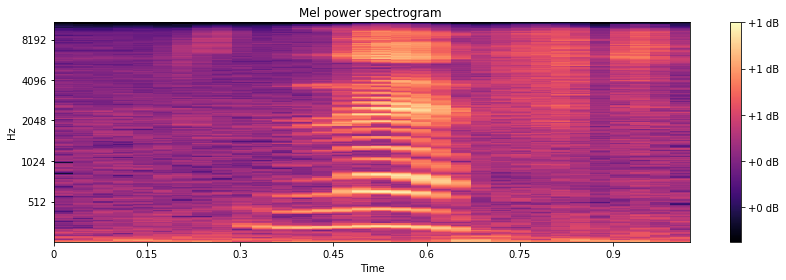

In [22]:
plot_mel(t)

In [23]:
b = model.predict(t.T.reshape(1,t.shape[1],t.shape[0]))[0].T

#### conv2d - mse

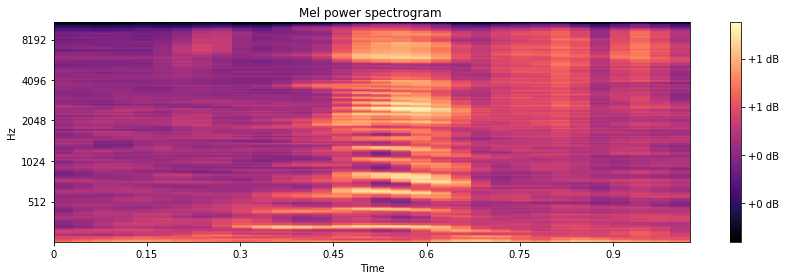

In [24]:
plot_mel(b) #(b-1.)*80

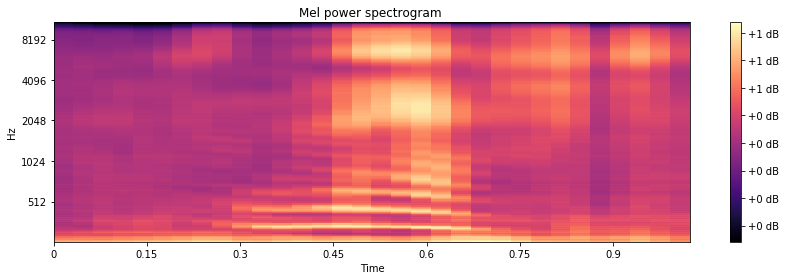

In [84]:
plot_mel(b) #(b-1.)*80

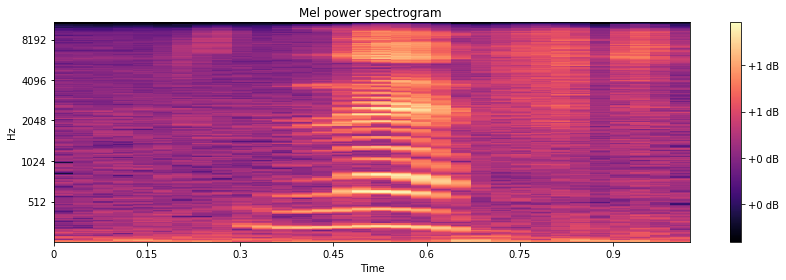

In [68]:
plot_mel(b) #(b-1.)*80

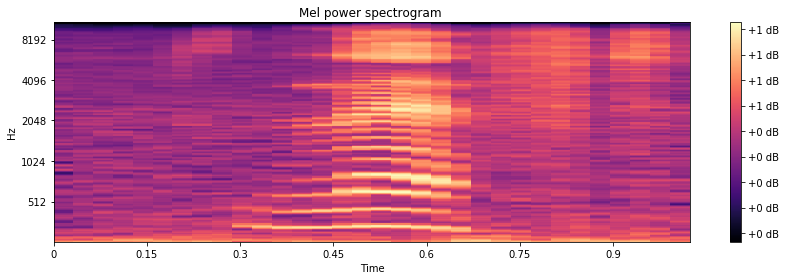

In [27]:
plot_mel(b) #(b-1.)*80

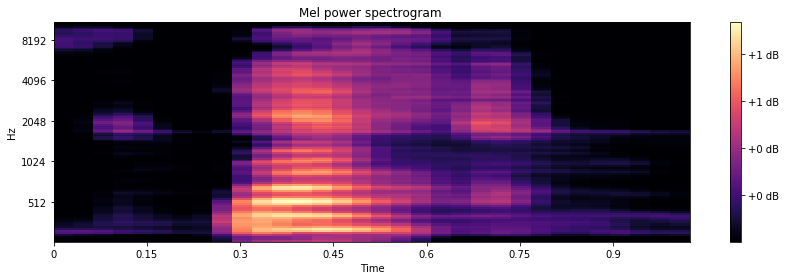

In [169]:
plot_mel(b) #(b-1.)*80

#### conv2d - bix

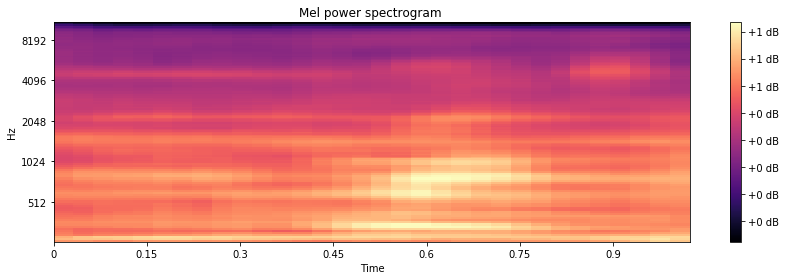

In [331]:
plot_mel(b) #(b-1.)*80

In [293]:
t.shape

(1, 128, 32)

In [139]:
model.load_weights('./weights/starter_pyramid_conv.hdf5')

In [155]:
def test_generator(test_batch_size,augment=False):
    while True:
        for start in range(0, len(test_paths), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(test_paths))
            this_paths = test_paths[start:end]
            for x in this_paths:
                x_batch.append(process_wav_file(x,reshape=True,augment=augment,pval=0.5))
            x_batch = np.array(x_batch)
            yield x_batch

In [143]:
predictions = model.predict_generator(test_generator(64,augment=False), int(np.ceil(len(test_paths)/64.)), verbose=1)

2478/2478 [==============================] - 1230s  


In [152]:
np.save("cache/predictions_pyramid_noaug.npy",predictions)

In [156]:
num_aug = 2 
for i in range(num_aug):
    predictions +=  model.predict_generator(test_generator(64,augment=True), int(np.ceil(len(test_paths)/64.)), verbose=1)
    

2477/2478 [============================>.] - ETA: 0s

In [157]:
predictions = predictions/(num_aug + 1.0)

In [158]:
classes = np.argmax(predictions, axis=1)

In [159]:
# last batch will contain padding, so remove duplicates
submission = dict()
for i in range(len(test_paths)):
    fname, label = os.path.basename(test_paths[i]), id2name[classes[i]]
    submission[fname] = label

In [160]:
with open('subm/starter_submission{}_3xtta.csv'.format(exp_name), 'w') as fout:
    fout.write('fname,label\n')
    for fname, label in submission.items():
        fout.write('{},{}\n'.format(fname, label))